# CE-40717: Machine Learning
## HW5-Q6: *Reinforcement Learning*

*Full name:* Sayed Hesam Alavian



In this notebook, you are going to implement Q-learning and SARSA on Taxi-v3 environment from Gym, and encounter some of the challenges in reinforcement learning meanwhile. Please complete the code in the given format according to the comments in each part.

# Taxi-v3

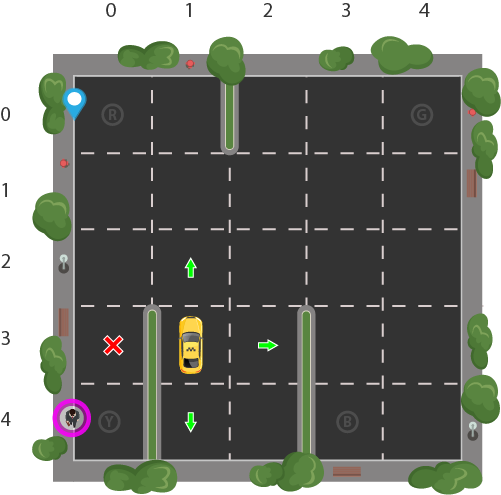

*image from [this link](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)*

This environment simulates a self-driving cab in a simplified way. The cab should pick up a passenger from a source location and drop off at a goal destination inside a $5\times5$ grid with internal walls at fixed positions. The passenger can be in four possible locations (R, G, Y, B) before getting into the cab, and the destination can be any of these four locations as well. States can be expressed via three locations: the moving cab ($5\times5$), the passenger ($4 + 1$), and the destination ($4$). So there is $5\times5\times5\times4=500$ distinct states. 

The cab can move in four main directions and pick up/drop off the passenger. So the action space contains six corresponding actions. Finally, for every movement, there is a $-1$ reward (to encourage more straightforward movement towards the passenger and destination). If the agent tries to pick up/drop off the passenger out of place, it will receive a $-10$ reward, and for appropriately dropping off the passenger, a $+20$ reward will be given.

You can run the following cells to see the specifications of the environment and the results of the completely random policy. The passenger and the destination are shown by blue and purple characters respectively.

In [ ]:
!pip install texttable
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
from texttable import Texttable

# You can use these methods later in the code.
def print_frames(frames, env, show_transition=True, wait_time=0):
    """
    This method renders an episode. 

    - frames: an array of per-timestep dictionaries with ('frame', 'state', 
      'reward', 'action') as keys;
      You can record the frame at every state using env.render(mode='ansi').
    - env: an instance of Taxi-v3 environment;
    - show_transition:‌ whether to print the transition table at every timestep;
    - wait_time: time step between consecutive frames;
    """
    action_mappings = ['South', 'North', 'East', 'West', 'Pickup', 'Dropoff']
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(f"Timestep: {i + 1}")

        print(frame['frame'])

        print(f"State: {frame['state']}")
        print(f"Action: {action_mappings[frame['action']]} ({frame['action']})")
        print(f"Reward: {frame['reward']}")
        
        if show_transition:
            rows = [['action', 'probability', 'next state', 'reward', 'done']]
            for k, v in env.P[frame['state']].items():
                probability, nextstate, reward, done = v[0]
                rows.append([k, probability, nextstate, reward, done])
            table = Texttable()
            table.add_rows(rows)

            print(f"\nTransitions at {frame['state']}:")
            print(table.draw())
        sleep(wait_time)

def plot_curves(curves, title, smooth=True, w_size=50):
    """
    This method plots series specified in `curves['series']`
    inside the same figure.

    - curves: a dictionary, dict(curves=a list of lists, labels=a list of strings);
    - title: figure's title;
    - smooth: whether to take a moving average over each series;
    - w_size: size of the moving average window;

    Notice: Series must have the same length.
    """
    series, labels = curves['series'], curves['labels']  
    N = len(series[0])
    assert all([len(s) == N for s in series])     
    x = list(range(N))
    for s, label in zip(series, labels):
        window = np.ones(w_size)/w_size
        s_smooth = np.convolve(s, window, mode='same')
        y = s_smooth[w_size:N-w_size] if smooth else s
        plt.plot(x[w_size:N-w_size], y, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
# Let's instantiate the environment and see its properties.
env_id = "Taxi-v3"
env = gym.make(env_id)
spec = gym.spec(env_id)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8



In [ ]:
# A demo of the completely random policy
state = env.reset()
done = False
frames = []
while not done:
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
print_frames(frames, env)

Timestep: 200
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 107
Action: Dropoff (5)
Reward: -10

Transitions at 107:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 207        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 7          | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 127        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 107        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 107        | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 107        | -10    | 0    |
+--------+-------------+------------+--------+------+


# Implementation

In [ ]:
class TDRL():
    def __init__(self, env_id='Taxi-v3', epsilon=0.15, alpha=0.1, gamma=0.6, 
                 mode='q_learning', decay_rate=0.9999, decay_epsilon=True):
        
        assert env_id == 'Taxi-v3', 'Only Taxi-v3 environment is supported.'
        self.env = gym.make(env_id)
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        self.epsilon = 1
        self.fixed_eps = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.mode = mode # a string, 'SARSA' for SARSA and 'q_learning' for Q-learning
        self.decay_epsilon = decay_epsilon
        self.decay_rate = decay_rate

    def select_action(self, state, eval=False):
        ################ ToDo (5 points) ###############
        # Select the action based on state. Use        #
        # epsilon-greedy action selection during       #
        # training phase in the following cases:       #
        # 1) fixed epsilon (equal to self.fixed_eps)   #
        # 2) decaying epsilon (1 to self.fixed_eps)    #
        #    with the multiplicative rate specified in #
        #    self.decay_rate.                          #
        # `eval` indicates whether it is training time #
        # or not. Don't apply epsilon-greedy selection #
        # at test time.                                #
        ################################################
        if eval:
            return np.argmax(self.Q[state])
        else:
            if self.decay_epsilon and self.epsilon > self.fixed_eps:
                self.epsilon = self.epsilon * self.decay_rate
            else:
                self.epsilon = self.fixed_eps
            if np.random.uniform(0, 1) < self.epsilon:
                return self.env.action_space.sample()
            else:
                return np.argmax(self.Q[state])

    def update_Q(self, reward, state, next_state, action, next_action, done):
        ################ ToDo (5 points) ##################
        # Update Q-table according to the specified SARSA #
        # or Q-learning update rule.                      #
        ###################################################
        if self.mode == 'q_learning':
            self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * (reward + self.gamma * np.max(self.Q[next_state]))
        elif self.mode == 'SARSA':
            self.Q[state, action] = (1 - self.alpha) * self.Q[state, action] + self.alpha * (reward + self.gamma * self.Q[next_state, next_action])

    def run_episodes(self, n_episodes):
        #################### ToDo (6 points) #####################
        # At every step of each episode, you should:             #
        # 1) choose proper action (eval=False)                   #
        # 2) execute that action in the environment.             #
        # 3) update Q-table accordingly.                         #
        # 4) record discounted total return of each episode.     #
        # 5) record number of times the agent gets a -10 reward  #
        #    during each episode (called penalty).               #
        # 6) plot total return and penalty across episodes       #
        ##########################################################
        NUM_penalties = []
        NUM_disconnect_total_return = []
        for episode in range(n_episodes):
            state = self.env.reset()            
            discounted_total_return = 0
            step_number = 0
            penalties = 0
            done = False
############################# PART 1 ####################################            
            action = self.select_action(state, eval=False)
############################# PART 2 ####################################             
            while not done:
                next_state, reward, done, _ = self.env.step(action)
############################# PART 3 #################################### 
                next_action = self.select_action(next_state, eval=False)
                self.update_Q(reward, state, next_state, action, next_action, done) 
                action = next_action
                state = next_state
############################# PART 4 #################################### 
                discounted_total_return += (self.gamma ** step_number) * reward
############################# PART 5 #################################### 
                if reward == -10:
                    penalties += 1
                step_number += 1            
            NUM_disconnect_total_return.append(discounted_total_return)
            NUM_penalties.append(penalties)
            if (episode + 1) % 100 == 0:
                print('Episode ' , episode + 1, ' is finished')
############################# PART 6 #################################### 
        # plt.style.use(['ggplot'])
        # plt.rc('axes', facecolor='r')
        # plt.rc('figure', facecolor='g')
        # plt.rc('figure', figsize=(10, 6), dpi=100)
        plt.figure(figsize = (15,15))
        fig, ax = plt.subplots(1, 2)
        xaxis = range(1, n_episodes + 1)
        ax[0].plot(xaxis, NUM_disconnect_total_return, c='b')
        ax[0].set_xlabel('Number of Episode')
        ax[0].set_ylabel('Total Return')
        ax[1].plot(xaxis, NUM_penalties, c='r')
        ax[1].set_xlabel('Number of Episode')
        ax[1].set_xlabel('Number of penalties')
        plt.show()


    def evaluate(self, n_episodes, print_res=True):
        ##################### ToDo (4 points) ####################
        # Similar to training time, run evaluation episodes and  #
        # report average total return, penalty, episode          #
        # length, and success rate across episodes. An episode   #
        # is considered successful if reward is 20 in the last   #
        # step.                                                  #
        # Also record frames for the episode with highest return #
        # and print it using `print_frames`.                     #
        ##########################################################
        NUM_disconnect_total_return = []
        NUM_penalties = []
        episode_lengths = []
        success = []
        best_return = float('-inf')
        best_episode_frames = None        
        for episode in range(n_episodes):
            state = self.env.reset()            
            discounted_total_return = 0
            step_number = 0
            penalties = 0
            done = False
            frames = []
            while not done:
                action = self.select_action(state, eval=True) 
                next_state, reward, done, _ = self.env.step(action)
                discounted_total_return += (self.gamma ** step_number) * reward
                if reward == -10:
                    penalties += 1
                step_number += 1
                frames.append({
                    'frame': self.env.render(mode='ansi'),
                    'state': state,
                    'action': action,
                    'reward': reward
                    }
                )
                state = next_state

            NUM_disconnect_total_return.append(discounted_total_return)
            NUM_penalties.append(penalties)
            episode_lengths.append(step_number)
            if reward == 20:
                success.append(1)
            else:
                success.append(0)
            if discounted_total_return > best_return:
                best_return = discounted_total_return
                best_episode_frames = frames
            if (episode + 1) % 100 == 0:
                print('Episode ' , episode + 1, ' is finished')
        
        Average_total_return = sum(NUM_disconnect_total_return) / len(NUM_disconnect_total_return)
        Average_number_of_penalties = sum(NUM_penalties) / len(NUM_penalties)
        Average_number_of_penalties = sum(episode_lengths) / len(episode_lengths)
        Success_rate = sum(success) / len(success)

        print_frames(best_episode_frames, self.env, wait_time=0.1)
        print('Average total return:', Average_total_return)        
        print('Average number of penalties: ', Average_number_of_penalties)
        print('Average number of penalties: ', Average_number_of_penalties)
        print('Success rate: ', Success_rate)
        return (Average_total_return, Average_number_of_penalties, Average_number_of_penalties, Success_rate)

# Comparisons

In [ ]:
n_episodes_train = 8000
n_episodes_test = 500
# You can change parameters of TDRL as you wish.

## Decaying epsilon

Episode  100  is finished
Episode  200  is finished
Episode  300  is finished
Episode  400  is finished
Episode  500  is finished
Episode  600  is finished
Episode  700  is finished
Episode  800  is finished
Episode  900  is finished
Episode  1000  is finished
Episode  1100  is finished
Episode  1200  is finished
Episode  1300  is finished
Episode  1400  is finished
Episode  1500  is finished
Episode  1600  is finished
Episode  1700  is finished
Episode  1800  is finished
Episode  1900  is finished
Episode  2000  is finished
Episode  2100  is finished
Episode  2200  is finished
Episode  2300  is finished
Episode  2400  is finished
Episode  2500  is finished
Episode  2600  is finished
Episode  2700  is finished
Episode  2800  is finished
Episode  2900  is finished
Episode  3000  is finished
Episode  3100  is finished
Episode  3200  is finished
Episode  3300  is finished
Episode  3400  is finished
Episode  3500  is finished
Episode  3600  is finished
Episode  3700  is finished
Episode  3

<Figure size 1080x1080 with 0 Axes>

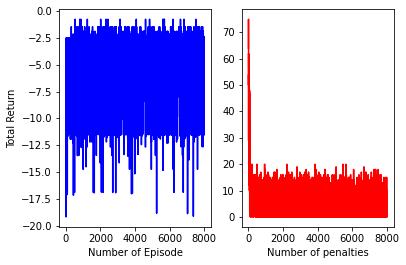

In [ ]:
sarsa = TDRL(mode='SARSA')
sarsa_out = sarsa.run_episodes(n_episodes_train)

In [ ]:
sarsa_eval = sarsa.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 16
Action: Dropoff (5)
Reward: 20

Transitions at 16:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 116        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 36         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 16         | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 0          | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total return

Episode  100  is finished
Episode  200  is finished
Episode  300  is finished
Episode  400  is finished
Episode  500  is finished
Episode  600  is finished
Episode  700  is finished
Episode  800  is finished
Episode  900  is finished
Episode  1000  is finished
Episode  1100  is finished
Episode  1200  is finished
Episode  1300  is finished
Episode  1400  is finished
Episode  1500  is finished
Episode  1600  is finished
Episode  1700  is finished
Episode  1800  is finished
Episode  1900  is finished
Episode  2000  is finished
Episode  2100  is finished
Episode  2200  is finished
Episode  2300  is finished
Episode  2400  is finished
Episode  2500  is finished
Episode  2600  is finished
Episode  2700  is finished
Episode  2800  is finished
Episode  2900  is finished
Episode  3000  is finished
Episode  3100  is finished
Episode  3200  is finished
Episode  3300  is finished
Episode  3400  is finished
Episode  3500  is finished
Episode  3600  is finished
Episode  3700  is finished
Episode  3

<Figure size 1080x1080 with 0 Axes>

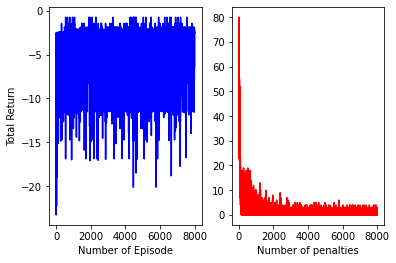

In [ ]:
q_learning = TDRL(mode='q_learning')
q_learning_out = q_learning.run_episodes(n_episodes_train)

In [ ]:
q_learning_eval = q_learning.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 418
Action: Dropoff (5)
Reward: 20

Transitions at 418:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 318        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 418        | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 410        | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total retu

## Fixed epsilon

Episode  100  is finished
Episode  200  is finished
Episode  300  is finished
Episode  400  is finished
Episode  500  is finished
Episode  600  is finished
Episode  700  is finished
Episode  800  is finished
Episode  900  is finished
Episode  1000  is finished
Episode  1100  is finished
Episode  1200  is finished
Episode  1300  is finished
Episode  1400  is finished
Episode  1500  is finished
Episode  1600  is finished
Episode  1700  is finished
Episode  1800  is finished
Episode  1900  is finished
Episode  2000  is finished
Episode  2100  is finished
Episode  2200  is finished
Episode  2300  is finished
Episode  2400  is finished
Episode  2500  is finished
Episode  2600  is finished
Episode  2700  is finished
Episode  2800  is finished
Episode  2900  is finished
Episode  3000  is finished
Episode  3100  is finished
Episode  3200  is finished
Episode  3300  is finished
Episode  3400  is finished
Episode  3500  is finished
Episode  3600  is finished
Episode  3700  is finished
Episode  3

<Figure size 1080x1080 with 0 Axes>

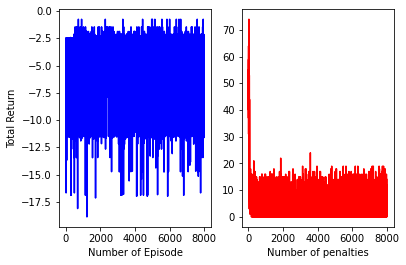

In [ ]:
sarsa_fixed = TDRL(mode='SARSA', decay_epsilon=False)
sarsa_fixed_out = sarsa_fixed.run_episodes(n_episodes_train)

In [ ]:
sarsa_fixed_eval = sarsa_fixed.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 16
Action: Dropoff (5)
Reward: 20

Transitions at 16:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 116        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 36         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 16         | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 16         | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 0          | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total return

Episode  100  is finished
Episode  200  is finished
Episode  300  is finished
Episode  400  is finished
Episode  500  is finished
Episode  600  is finished
Episode  700  is finished
Episode  800  is finished
Episode  900  is finished
Episode  1000  is finished
Episode  1100  is finished
Episode  1200  is finished
Episode  1300  is finished
Episode  1400  is finished
Episode  1500  is finished
Episode  1600  is finished
Episode  1700  is finished
Episode  1800  is finished
Episode  1900  is finished
Episode  2000  is finished
Episode  2100  is finished
Episode  2200  is finished
Episode  2300  is finished
Episode  2400  is finished
Episode  2500  is finished
Episode  2600  is finished
Episode  2700  is finished
Episode  2800  is finished
Episode  2900  is finished
Episode  3000  is finished
Episode  3100  is finished
Episode  3200  is finished
Episode  3300  is finished
Episode  3400  is finished
Episode  3500  is finished
Episode  3600  is finished
Episode  3700  is finished
Episode  3

<Figure size 1080x1080 with 0 Axes>

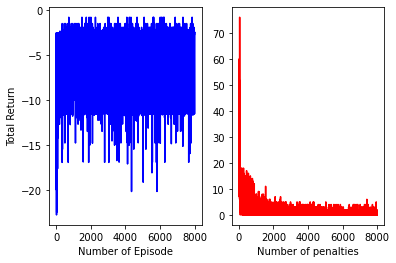

In [ ]:
q_learning_fixed = TDRL(mode='q_learning', decay_epsilon=False)
q_learning_fixed_out = q_learning_fixed.run_episodes(n_episodes_train)

In [ ]:
q_learning_fixed_eval = q_learning.evaluate(n_episodes_test)

Timestep: 6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

State: 418
Action: Dropoff (5)
Reward: 20

Transitions at 418:
+--------+-------------+------------+--------+------+
| action | probability | next state | reward | done |
+========+=============+============+========+======+
| 0      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 1      | 1           | 318        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 2      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 3      | 1           | 418        | -1     | 0    |
+--------+-------------+------------+--------+------+
| 4      | 1           | 418        | -10    | 0    |
+--------+-------------+------------+--------+------+
| 5      | 1           | 410        | 20     | 1    |
+--------+-------------+------------+--------+------+
Average total retu

**Question (5 points):**

Compare these methods and explain your results bsed on average return, penalty, episode length and success rate. It would be nice to plot learning curves using `plot_curves` method.

**Answer:** ...


In [ ]:
# Code for comparison plots, table, ...
rows = [['method', 'episode length', 'penalties', 'average return', 'success']]
rows.append(['SARSA decaying epsilon', sarsa_eval[0], sarsa_eval[1], sarsa_eval[2],sarsa_eval[3]])
rows.append(['SARSA fixed epsilon', sarsa_fixed_eval[0], sarsa_fixed_eval[1],sarsa_fixed_eval[2], sarsa_fixed_eval[3]])
rows.append(['Q-learning decaying epsilon', q_learning_eval[0], q_learning_eval[1], q_learning_eval[2], q_learning_eval[3]])
rows.append(['Q-learning fixed epsilon', q_learning_fixed_eval[0], q_learning_fixed_eval[1], q_learning_fixed_eval[2], q_learning_fixed_eval[3]])
table = Texttable()
table.add_rows(rows)
print(table.draw())

+----------------------+----------------+-----------+----------------+---------+
|        method        | episode length | penalties | average return | success |
+======================+================+===========+================+=========+
| SARSA decaying       | -2.444         | 124.082   | 124.082        | 0.408   |
| epsilon              |                |           |                |         |
+----------------------+----------------+-----------+----------------+---------+
| SARSA fixed epsilon  | -2.421         | 123.332   | 123.332        | 0.410   |
+----------------------+----------------+-----------+----------------+---------+
| Q-learning decaying  | -2.357         | 30.262    | 30.262         | 0.906   |
| epsilon              |                |           |                |         |
+----------------------+----------------+-----------+----------------+---------+
| Q-learning fixed     | -2.381         | 33.656    | 33.656         | 0.888   |
| epsilon              |    

<div dir=RTL >
همانطور که می بینیم نرخ موفقیت در q-learning به طور قابل توجهی بالاتر از SARSA است، پس با استفاده از q-learning، سیاست های بهتری را یاد می گیریم و در بیشتر مواقع به هدفی دست می‌یابیم که مشتری را از مکان مناسب انتخاب کرده و آنها را به مقصد خود می‌رساند. در نتیجه مدت زمان episode برای q-learning نیز بسیار کمتر است، به این معنی که عامل زمان را برای سرگردانی تلف نمی‌کند و در عوض مستقیماً از محل شروع به مقصد می‌رود. و در نهایت میانگین بازده بالاتر برای q-learning ثابت می کند که این الگوریتم بهتر بوده است.
برای هر دو الگوریتم استفاده از decaying epsilon عملکرد را بهبود می بخشد. این به این دلیل است که decaying epsilon  در ابتدا بیشتر کاوش میکنیم و تا زمانی که به پایان رسیدیم از آموخته‌ها بهره برداری میکنیم زیرا بیشتر محیط قبلاً کاوش شده است.
به طور کلی در این تمرین Q-learning with decaying epsilon بهترین نتایج را به دست آورد.
</div>